# Intro on this code:
Guidelines to install python and jupyter notebook HERE: https://github.com/PaulCarrascosa/LMT_Widget_Tool-LWT?tab=readme-ov-file
## packages to install in python (or anaconda) console ('pip install xxx') (or 'conda install xxx' if pip is not working):
- pandas
- scikit-learn
- matplotlib
- statsmodels

# 1) SDQp and SDQt separated (total SDQ score only):


Summary Statistics of SDQpADHD.csv
             SDQp        ADHD
count  370.000000  370.000000
mean    17.967568    0.797297
std      6.113119    0.402557
min      1.000000    0.000000
25%     14.000000    1.000000
50%     18.000000    1.000000
75%     22.750000    1.000000
max     34.000000    1.000000

Summary Statistics of SDQtADHD.csv
             SDQt        ADHD
count  170.000000  170.000000
mean    13.752941    0.782353
std      5.923388    0.413865
min      1.000000    0.000000
25%     10.000000    1.000000
50%     13.000000    1.000000
75%     18.000000    1.000000
max     29.000000    1.000000


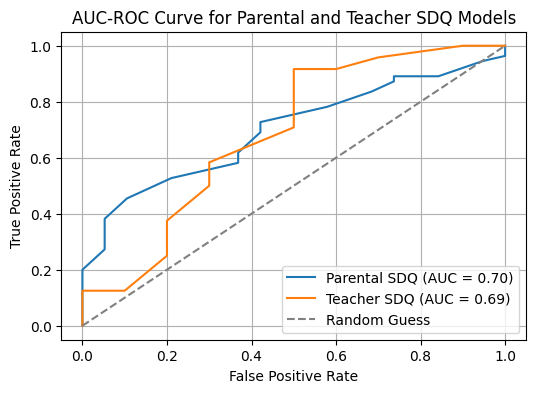

In [22]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load p&t SDQ data
sdqp = pd.read_csv("SDQpADHD.csv", sep=';')
sdqt = pd.read_csv("SDQtADHD.csv", sep=';')

# Ensure no missing values
sdqp = sdqp.dropna()
sdqt = sdqt.dropna()

# Descriptive summary
print(f"\nSummary Statistics of SDQpADHD.csv")
print(sdqp.describe(include="all"))
print(f"\nSummary Statistics of SDQtADHD.csv")
print(sdqt.describe(include="all"))

# Split parental SDQ data
X_p = sdqp[['SDQp']]  # Parental SDQ
y_p = sdqp['ADHD']    # Target
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

# Split teacher SDQ data
X_t = sdqt[['SDQt']]  # Teacher SDQ
y_t = sdqt['ADHD']    # Target
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

# Train models
model_p = LogisticRegression()
model_p.fit(X_train_p, y_train_p)
y_prob_p = model_p.predict_proba(X_test_p)[:, 1]
auc_p = roc_auc_score(y_test_p, y_prob_p)

model_t = LogisticRegression()
model_t.fit(X_train_t, y_train_t)
y_prob_t = model_t.predict_proba(X_test_t)[:, 1]
auc_t = roc_auc_score(y_test_t, y_prob_t)

# Calculate ROC curves
fpr_p, tpr_p, _ = roc_curve(y_test_p, y_prob_p)
fpr_t, tpr_t, _ = roc_curve(y_test_t, y_prob_t)

# Plot ROC curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_p, tpr_p, label=f"Parental SDQ (AUC = {auc_p:.2f})")
plt.plot(fpr_t, tpr_t, label=f"Teacher SDQ (AUC = {auc_t:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Parental and Teacher SDQ Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## 1.1) Combine the Models Indirectly (because not same subjects)

Combined Model AUC-ROC: 0.696


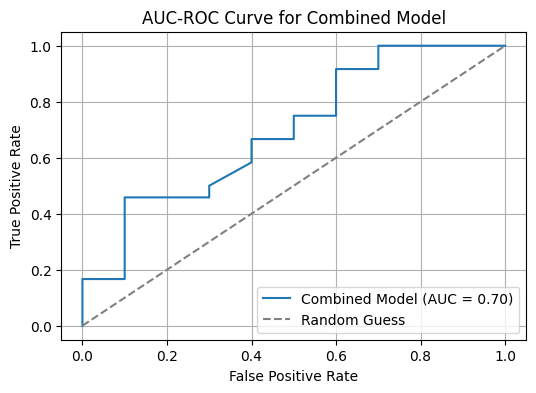

In [6]:
# Ensure that both arrays have the same length by taking the minimum length
min_length = min(len(y_prob_p), len(y_prob_t), len(y_test_p))

# Adjust arrays to the same length
adjusted_y_prob_p = y_prob_p[:min_length]
adjusted_y_prob_t = y_prob_t[:min_length]
adjusted_y_test_p = y_test_p[:min_length]

# Combine probabilities into a new dataset
combined_probs = pd.DataFrame({
    'y_prob_p': adjusted_y_prob_p,  # Parental SDQ predicted probabilities
    'y_prob_t': adjusted_y_prob_t,  # Teacher SDQ predicted probabilities
    'ADHD': adjusted_y_test_p       # True ADHD labels from parental dataset
}).dropna()

# Train a new model on combined probabilities
meta_model = LogisticRegression()
X_combined = combined_probs[['y_prob_p', 'y_prob_t']]
y_combined = combined_probs['ADHD']
meta_model.fit(X_combined, y_combined)

# Predict and evaluate combined model
y_meta_prob = meta_model.predict_proba(X_combined)[:, 1]
combined_auc = roc_auc_score(y_combined, y_meta_prob)
print(f"Combined Model AUC-ROC: {combined_auc:.3f}")

# Plot ROC curves
fpr_meta, tpr_meta, _ = roc_curve(y_combined, y_meta_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr_meta, tpr_meta, label=f"Combined Model (AUC = {combined_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Combined Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()


## 1.2) Advanced Models to Capture Complexity (Tree-based model)

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_combined, y_combined)

# Predict probabilities and calculate AUC-ROC
y_rf_prob = rf_model.predict_proba(X_combined)[:, 1]
rf_auc = roc_auc_score(y_combined, y_rf_prob)
print(f"Random Forest Combined Model AUC-ROC: {rf_auc:.3f}")


Random Forest Combined Model AUC-ROC: 0.996


#### plotting all together

Random Forest Combined Model AUC-ROC: 0.996


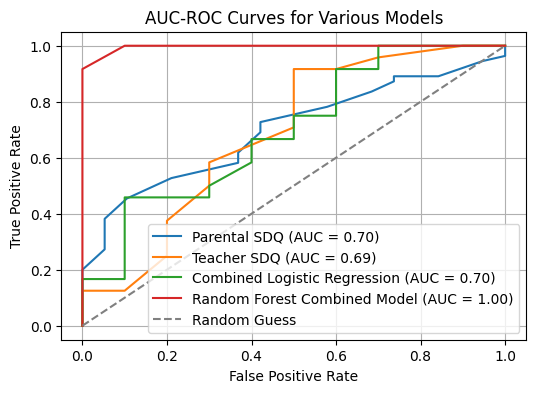

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_combined, y_combined)

# Predict probabilities and calculate AUC-ROC
y_rf_prob = rf_model.predict_proba(X_combined)[:, 1]
rf_auc = roc_auc_score(y_combined, y_rf_prob)
print(f"Random Forest Combined Model AUC-ROC: {rf_auc:.3f}")

# Calculate ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_combined, y_rf_prob)

# Plot all ROC curves
plt.figure(figsize=(6, 4))
# Parental SDQ (SDQp)
plt.plot(fpr_p, tpr_p, label=f"Parental SDQ (AUC = {auc_p:.2f})")
# Teacher SDQ (SDQt)
plt.plot(fpr_t, tpr_t, label=f"Teacher SDQ (AUC = {auc_t:.2f})")
# Combined Logistic Regression
plt.plot(fpr_meta, tpr_meta, label=f"Combined Logistic Regression (AUC = {combined_auc:.2f})")
# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest Combined Model (AUC = {rf_auc:.2f})")
# Random Guess
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves for Various Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()


### BE CAREFUL !! Random forrest is too-good-to-be-true (overfitting or data leakage) !!!

## 1.3) Cross-Validation for Generalizability

In [5]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for the Random Forest model
cv_scores = cross_val_score(rf_model, X_combined, y_combined, scoring='roc_auc', cv=5)

print(f"Cross-validated AUC-ROC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Cross-validated AUC-ROC: 0.695 ± 0.205


# 2) Data files SDQ P&T with Sub-scores

In [23]:
import pandas as pd
import glob

# Load all SDQp files
sdqp_files = glob.glob("SDQp*ADHD.csv")
sdqp_data = {}

for file in sdqp_files:
    # Extract subscore name from file name (e.g., "CD" from "SDQpCDADHD.csv")
    subscore_name = file.split("SDQp")[1].split("ADHD")[0].strip()
    sdqp_data[subscore_name] = pd.read_csv(file, sep=";").rename(columns={"Subscore": f"SDQp_{subscore_name}"})

# Combine SDQp data into one DataFrame
sdqp_combined = pd.concat(sdqp_data.values(), axis=1)
sdqp_combined = sdqp_combined.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']) # Drop unnamed columns
sdqp_combined = sdqp_combined.dropna(how='all') # Drop lines full of NaN

# Load all SDQt files
sdqt_files = glob.glob("SDQt*ADHD.csv")
sdqt_data = {}

for file in sdqt_files:
    # Extract subscore name from file name
    subscore_name = file.split("SDQt")[1].split("ADHD")[0].strip()
    sdqt_data[subscore_name] = pd.read_csv(file, sep=";").rename(columns={"Subscore": f"SDQt_{subscore_name}"})

# Combine SDQt data into one DataFrame
sdqt_combined = pd.concat(sdqt_data.values(), axis=1)
sdqt_combined = sdqt_combined.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
sdqt_combined = sdqt_combined.dropna(how='all') 

# Descriptive summary
print(f"\nSummary Statistics of SDQp*ADHD.csv")
print(sdqp_combined.describe(include="all"))
print(f"\nSummary Statistics of SDQt*ADHD.csv")
print(sdqt_combined.describe(include="all"))



Summary Statistics of SDQp*ADHD.csv
             SDQp        ADHD      SDQpCD        ADHD     SDQpEMO        ADHD  \
count  370.000000  370.000000  370.000000  370.000000  369.000000  370.000000   
mean    17.967568    0.797297    3.735135    0.797297    4.769648    0.797297   
std      6.113119    0.402557    2.351292    0.402557    2.917069    0.402557   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     14.000000    1.000000    2.000000    1.000000    2.000000    1.000000   
50%     18.000000    1.000000    4.000000    1.000000    4.000000    1.000000   
75%     22.750000    1.000000    5.000000    1.000000    7.000000    1.000000   
max     34.000000    1.000000   10.000000    1.000000   10.000000    1.000000   

         SDQpHypl        ADHD    SDQpPeer        ADHD     SDQpPro        ADHD  
count  370.000000  370.000000  370.000000  370.000000  370.000000  370.000000  
mean     6.572973    0.797297    2.937838    0.797297    6.905405    0.79

In [12]:
sdqp_combined

,SDQp,ADHD,SDQpCD,ADHD,SDQpEMO,ADHD,SDQpHypl,ADHD,SDQpPeer,ADHD,SDQpPro,ADHD
0,13,0,0,0,9.0,0,3,0,1,0,10,0
1,15,0,3,0,3.0,0,7,0,2,0,8,0
2,12,0,1,0,4.0,0,4,0,3,0,5,0
3,14,0,0,0,3.0,0,4,0,7,0,9,0
4,13,0,2,0,6.0,0,4,0,1,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
365,31,1,5,1,10.0,1,7,1,9,1,8,1
366,8,1,0,1,1.0,1,7,1,0,1,10,1
367,17,1,4,1,1.0,1,6,1,6,1,5,1
368,21,1,3,1,7.0,1,7,1,4,1,8,1


In [9]:
sdqt_combined

,SDQt,ADHD,SDQtCD,ADHD,SDQtEMO,ADHD,SDQtHypl,ADHD,SDQtPeer,ADHD,SDQtPro,ADHD
0,17.0,0.0,0.0,0.0,10.0,0.0,2.0,0.0,5.0,0.0,7.0,0.0
1,18.0,0.0,1.0,0.0,7.0,0.0,3.0,0.0,7.0,0.0,3.0,0.0
2,10.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,3.0,0.0,8.0,0.0
3,9.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,2.0,0.0,10.0,0.0
4,7.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
165,18.0,1.0,6.0,1.0,1.0,1.0,9.0,1.0,2.0,1.0,8.0,1.0
166,17.0,1.0,4.0,1.0,0.0,1.0,9.0,1.0,4.0,1.0,5.0,1.0
167,13.0,1.0,0.0,1.0,3.0,1.0,8.0,1.0,2.0,1.0,10.0,1.0
168,17.0,1.0,3.0,1.0,6.0,1.0,6.0,1.0,2.0,1.0,5.0,1.0


# 3) P&T TOGETHER: ALL score ("TOTAL SCORE") and subscores HISTOGRAMS and t-test BUT NO SEX and AGE


Summary Statistics of sexAgeSDQpSDQtClean.csv
             Sexe         age        ADHD  EMOTIONAL SYMPTOMS P  \
count  168.000000  168.000000  168.000000            167.000000   
mean     0.666667    8.880952    0.791667              4.802395   
std      0.472814    2.292423    0.407331              3.046308   
min      0.000000    6.000000    0.000000              0.000000   
25%      0.000000    7.000000    1.000000              2.000000   
50%      1.000000    8.500000    1.000000              5.000000   
75%      1.000000   10.000000    1.000000              7.000000   
max      1.000000   16.000000    1.000000             10.000000   

       CONDUCT PROBLEMS P  HYPERACTIVITY INATTENTION P  \
count           168.00000                   168.000000   
mean              3.64881                     6.678571   
std               2.32183                     2.656641   
min               0.00000                     0.000000   
25%               2.00000                     5.000000   
5

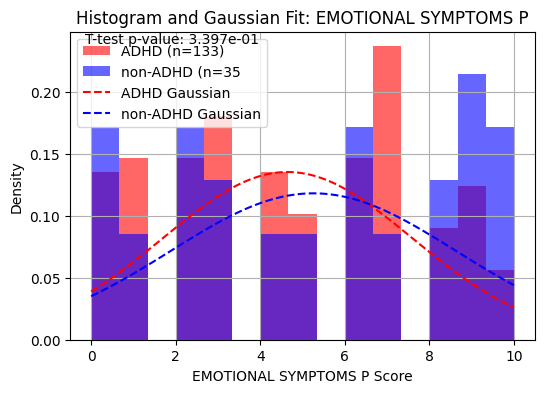

CONDUCT PROBLEMS P


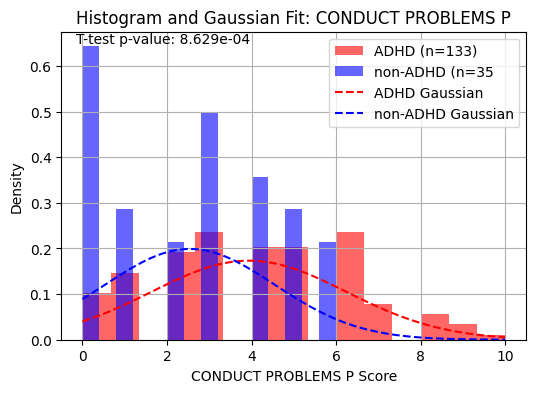

HYPERACTIVITY INATTENTION P


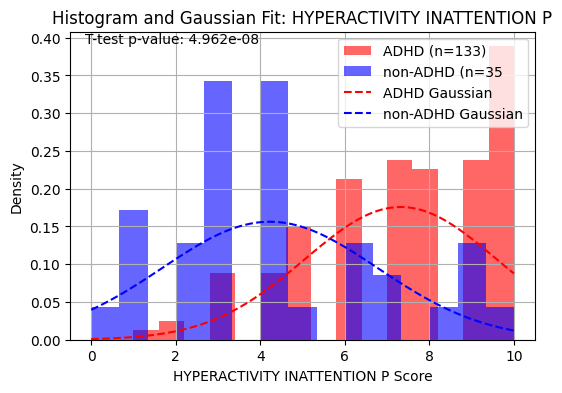

PEER RELATIONSHIP PROBLEMS P


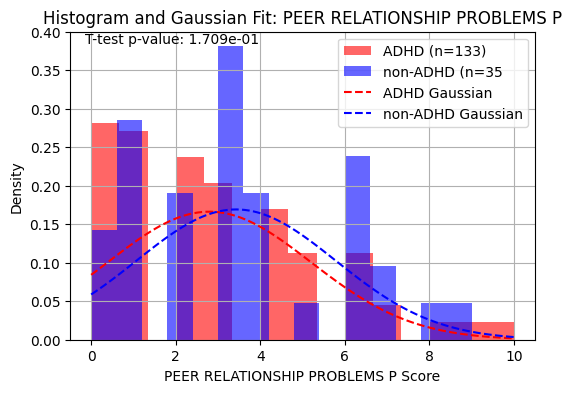

PROSOCIAL SCORE P


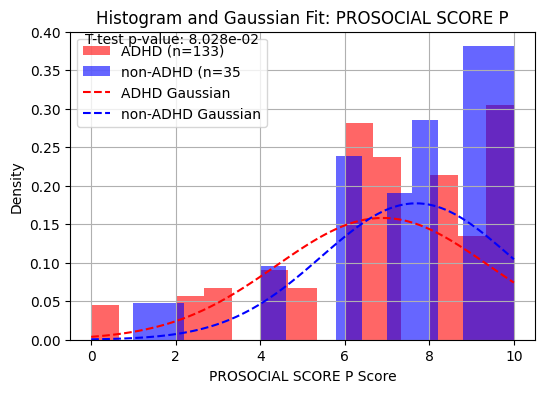

TOTAL SCORE P


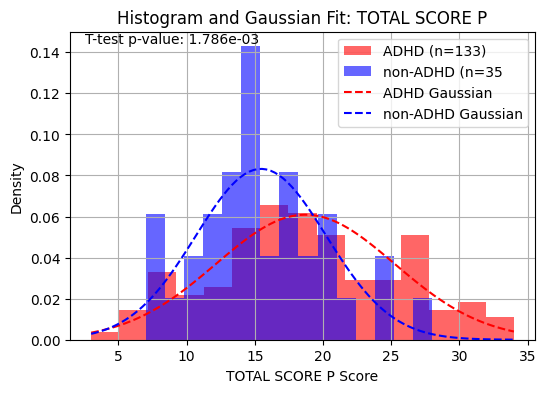

EMOTIONAL SYMPTOMS T


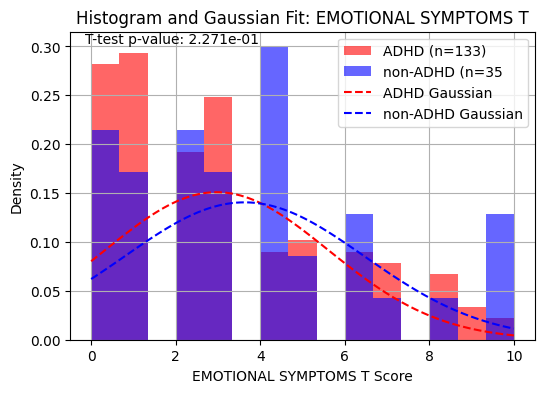

CONDUCT PROBLEMS T


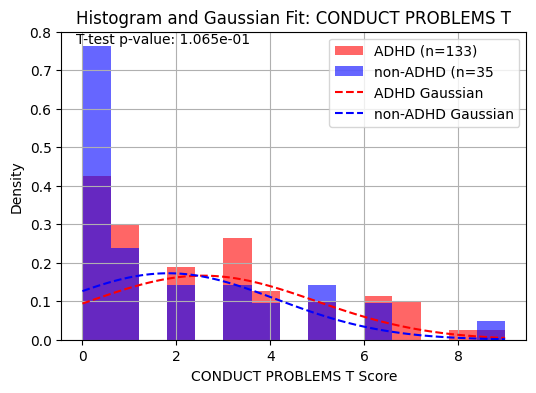

HYPERACTIVITY INATTENTION T


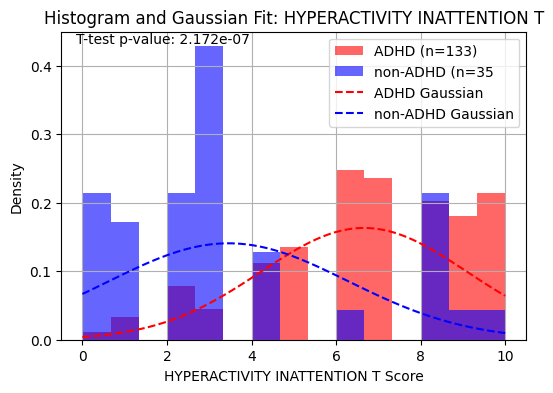

PEER RELATIONSHIP PROBLEMS T


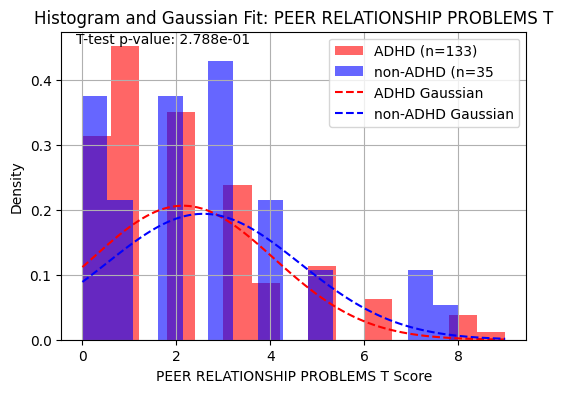

PROSOCIAL SCORE T


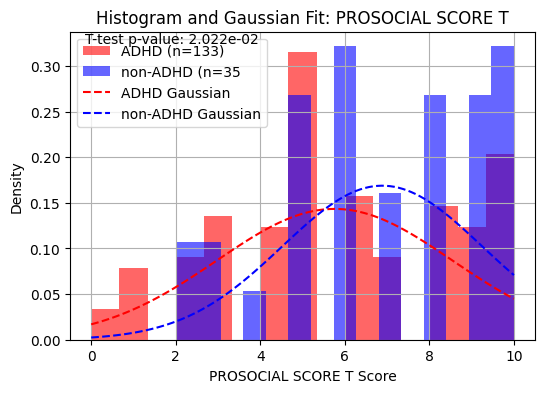

TOTAL SCORE T


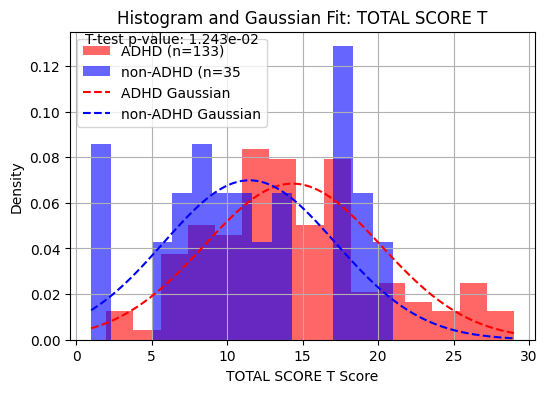

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm

# Load the dataset
file = "sexAgeSDQpSDQtClean.csv"
data = pd.read_csv(file, sep=";", skip_blank_lines=True).dropna(how='all', axis=1)  # Drop empty columns

# Descriptive summary
print(f"\nSummary Statistics of sexAgeSDQpSDQtClean.csv")
print(data.describe(include="all"))

# Print column names for verification
print("Columns in the dataset:", data.columns.tolist())

# Clean column names (remove leading/trailing spaces)
data.columns = data.columns.str.strip()

# Columns to analyze (parent and teacher SDQ subscores)
score_columns = [
    'EMOTIONAL SYMPTOMS P', 'CONDUCT PROBLEMS P', 'HYPERACTIVITY INATTENTION P', 'PEER RELATIONSHIP PROBLEMS P', 
    'PROSOCIAL SCORE P', 'TOTAL SCORE P',
    'EMOTIONAL SYMPTOMS T', 'CONDUCT PROBLEMS T', 'HYPERACTIVITY INATTENTION T', 'PEER RELATIONSHIP PROBLEMS T',
    'PROSOCIAL SCORE T', 'TOTAL SCORE T']
data['EMOTIONAL SYMPTOMS P'] = data['EMOTIONAL SYMPTOMS P'].fillna(0).astype(int) # Change NaN files

# Iterate through each score column
for score in score_columns:
    print(score)
    # Separate ADHD and Control groups
    adhd_group = data[data['ADHD'] == 1][score]
    control_group = data[data['ADHD'] == 0][score]

    # Fit Gaussian distributions
    adhd_mean, adhd_std = norm.fit(adhd_group)
    control_mean, control_std = norm.fit(control_group)

    # Count the number of subjects
    n_adhd = len(adhd_group.dropna())
    n_control = len(control_group.dropna())

    # Plot histogram FOr DENSITY 'density = True' | For Number 'density = false'
    plt.figure(figsize=(6, 4))
    plt.hist(adhd_group, bins=15, alpha=0.6, color='red', density=True, label=f'ADHD (n={n_adhd})')
    plt.hist(control_group, bins=15, alpha=0.6, color='blue', density=True, label=f'non-ADHD (n={n_control}')

    # plt.hist(adhd_group, bins=15, alpha=0.6, color='red', density=True, label='ADHD')
    # plt.hist(control_group, bins=15, alpha=0.6, color='blue', density=True, label='non-ADHD')

    # Overlay Gaussian distributions
    x = np.linspace(min(data[score]), max(data[score]), 100)
    plt.plot(x, norm.pdf(x, adhd_mean, adhd_std), color='red', linestyle='--', label='ADHD Gaussian')
    plt.plot(x, norm.pdf(x, control_mean, control_std), color='blue', linestyle='--', label='non-ADHD Gaussian')

    # Add title, labels, and legend
    plt.title(f"Histogram and Gaussian Fit: {score}")
    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()

    # Perform a statistical test
    t_stat, p_value = ttest_ind(adhd_group.dropna(), control_group.dropna(), equal_var=False)
    plt.figtext(0.15, 0.85, f"T-test p-value: {p_value:.3e}", fontsize=10, color='black')

    # Show plot
    plt.savefig(f"{score}")
    plt.show()


# 4) SDQ P&T Sex and Age Clean files:


########## SDQp Analysis ###############

First 5 rows of the data:
   Sexe  age  ADHD  EMOTIONAL SYMPTOMS P  CONDUCT PROBLEMS P  \
0     0   12     0                     9                   0   
1     1   14     0                     3                   3   
2     1   15     0                     4                   1   
3     1    9     0                     3                   0   
4     1    6     0                     6                   2   

   HYPERACTIVITY INATTENTION P  PEER RELATIONSHIP PROBLEMS P  \
0                            3                             1   
1                            7                             2   
2                            4                             3   
3                            4                             7   
4                            4                             1   

   PROSOCIAL SCORE P  TOTAL SCORE P  
0                 10             13  
1                  8             15  
2                  5             12  
3        

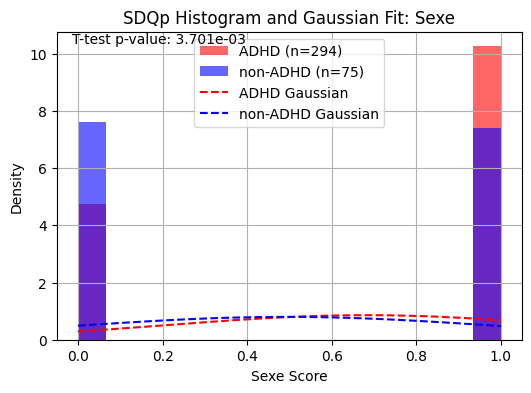

Current score analyzed: age


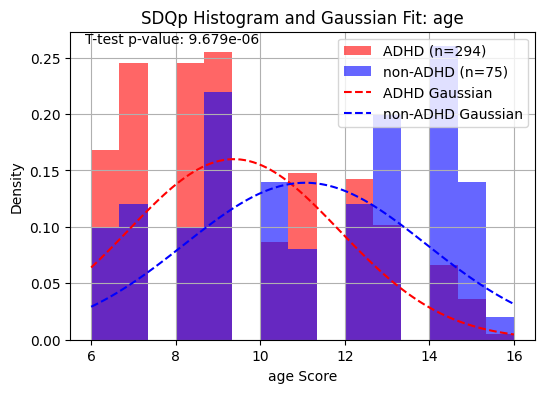

Current score analyzed: ADHD


C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


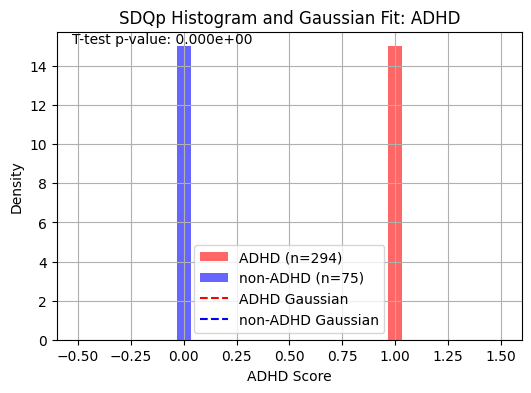

Current score analyzed: EMOTIONAL SYMPTOMS P


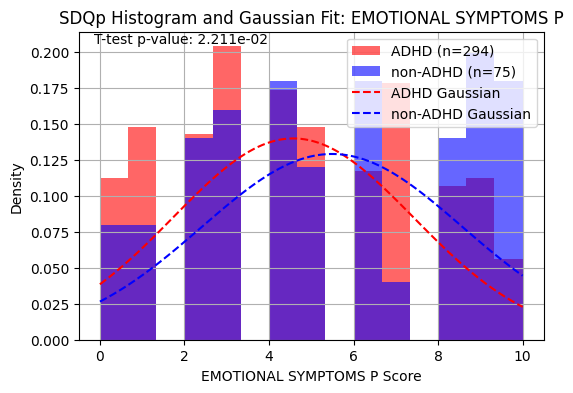

Current score analyzed: CONDUCT PROBLEMS P


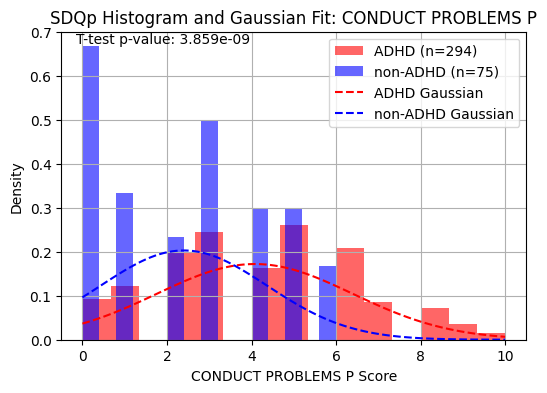

Current score analyzed: HYPERACTIVITY INATTENTION P


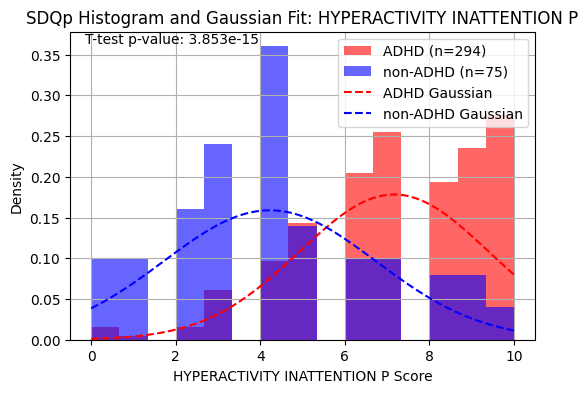

Current score analyzed: PEER RELATIONSHIP PROBLEMS P


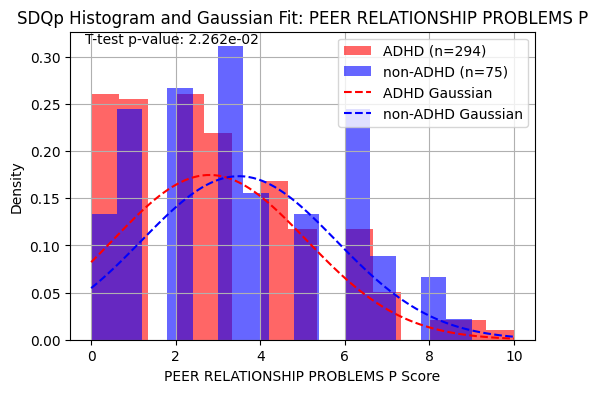

Current score analyzed: PROSOCIAL SCORE P


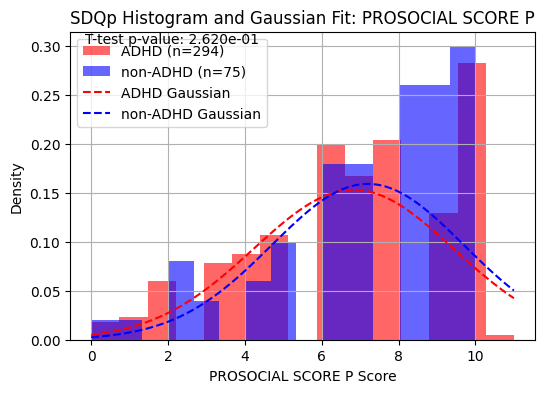

Current score analyzed: TOTAL SCORE P


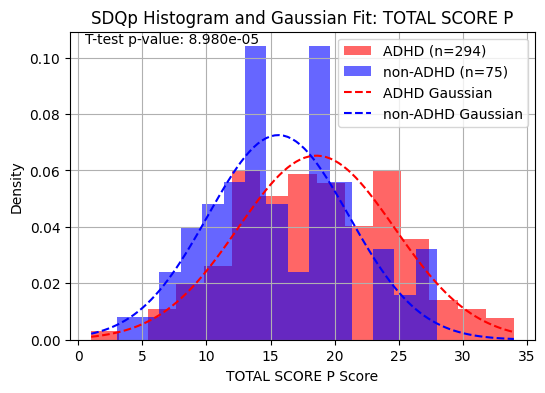


########## SDQt Analysis ###############

First 5 rows of the data:
   Sexe  age  ADHD  EMOTIONAL SYMPTOMS T  CONDUCT PROBLEMS T  \
0     0   12     0                    10                   0   
1     1    9     0                     7                   1   
2     1    6     0                     4                   0   
3     0    9     0                     4                   0   
4     1    6     0                     0                   3   

   HYPERACTIVITY INATTENTION T  PEER RELATIONSHIP PROBLEMS T  \
0                            2                             5   
1                            3                             7   
2                            3                             3   
3                            3                             2   
4                            2                             2   

   PROSOCIAL SCORE T  TOTAL SCORE T  
0                  7             17  
1                  3             18  
2                  8             10  
3        

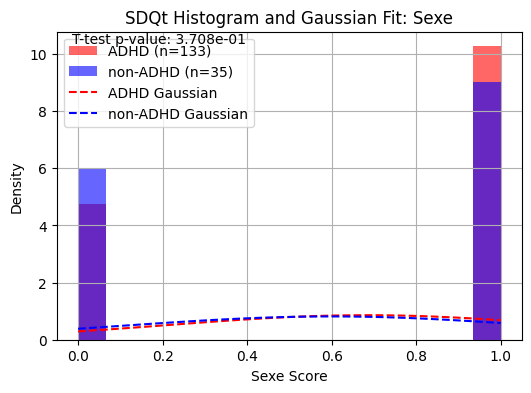

Current score analyzed: age


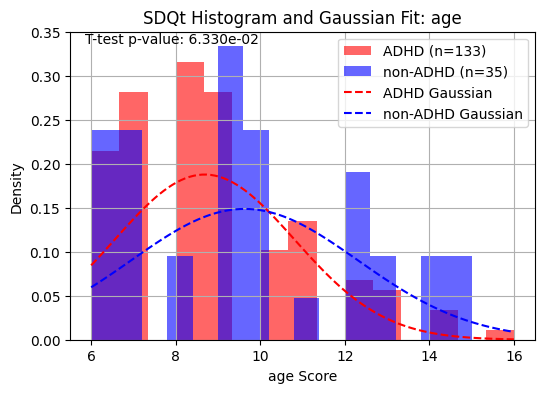

Current score analyzed: ADHD


C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_distn_infrastructure.py:2027: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


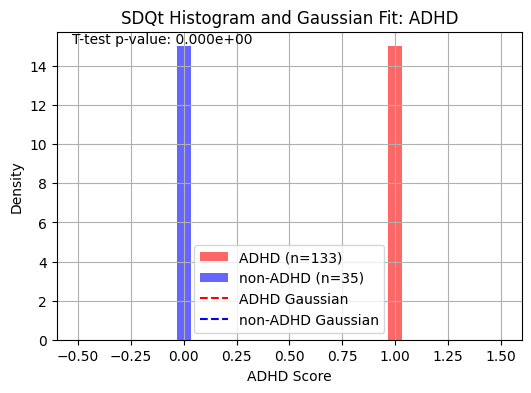

Current score analyzed: EMOTIONAL SYMPTOMS T


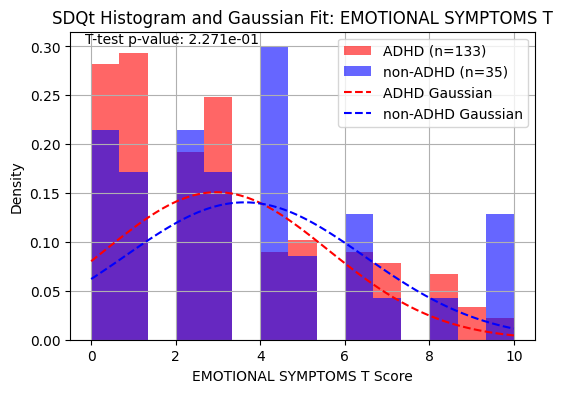

Current score analyzed: CONDUCT PROBLEMS T


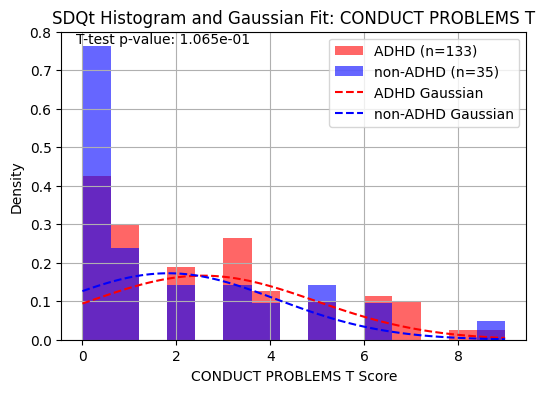

Current score analyzed: HYPERACTIVITY INATTENTION T


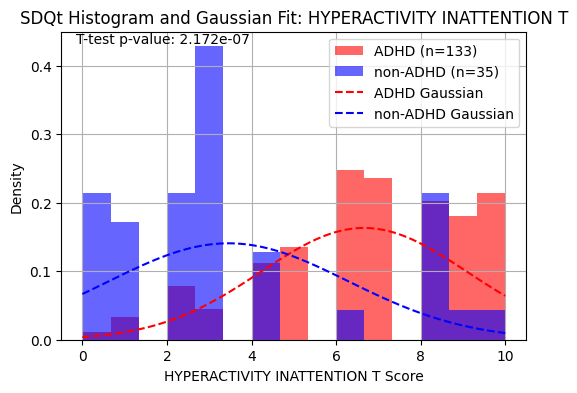

Current score analyzed: PEER RELATIONSHIP PROBLEMS T


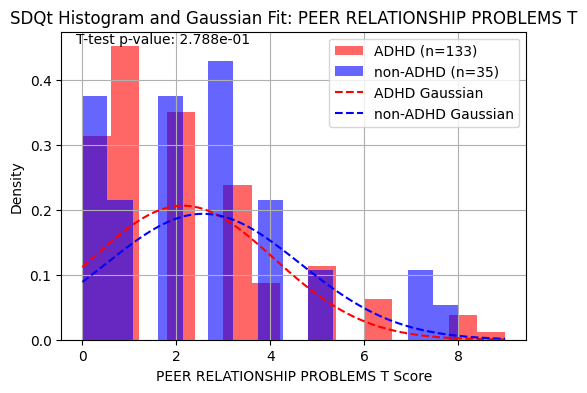

Current score analyzed: PROSOCIAL SCORE T


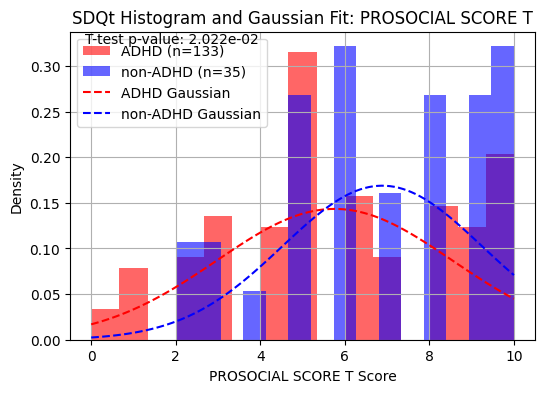

Current score analyzed: TOTAL SCORE T


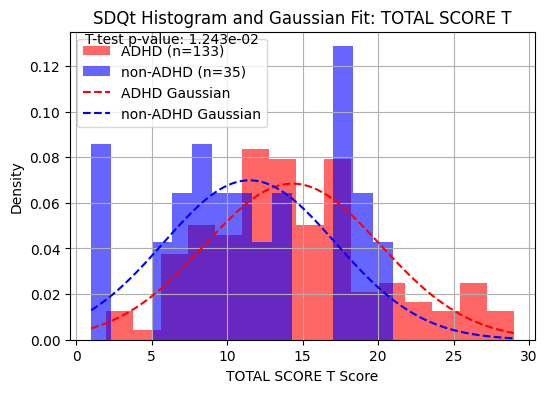

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm

# Load the datasets
file_sdqp_clean = "sexAgeSDQpClean.csv"
file_sdqp_clean = pd.read_csv(file_sdqp_clean, sep=";", skip_blank_lines=True).dropna(how='all', axis=1) # Drop empty columns

file_sdqt_clean = "sexAgeSDQtClean.csv"
file_sdqt_clean = pd.read_csv(file_sdqt_clean, sep=";", skip_blank_lines=True).dropna(how='all', axis=1)  # Drop empty columns

# Clean column names (remove leading/trailing spaces)
file_sdqp_clean.columns = file_sdqp_clean.columns.str.strip()
file_sdqt_clean.columns = file_sdqt_clean.columns.str.strip()

# Columns to analyze (parent and teacher SDQ subscores)
score_columns_sdqp = [ 'Sexe', 'age', 'ADHD', 
    'EMOTIONAL SYMPTOMS P', 'CONDUCT PROBLEMS P', 'HYPERACTIVITY INATTENTION P', 'PEER RELATIONSHIP PROBLEMS P', 
    'PROSOCIAL SCORE P', 'TOTAL SCORE P']
score_columns_sdqt = ['Sexe', 'age', 'ADHD', 
    'EMOTIONAL SYMPTOMS T', 'CONDUCT PROBLEMS T', 'HYPERACTIVITY INATTENTION T', 'PEER RELATIONSHIP PROBLEMS T',
    'PROSOCIAL SCORE T', 'TOTAL SCORE T']

file_sdqp_clean['EMOTIONAL SYMPTOMS P'] = file_sdqp_clean['EMOTIONAL SYMPTOMS P'].fillna(0).astype(int) # Change NaN files
file_sdqt_clean['EMOTIONAL SYMPTOMS T'] = file_sdqt_clean['EMOTIONAL SYMPTOMS T'].fillna(0).astype(int) # Change NaN files

print("\n########## SDQp Analysis ###############\n")

# Display the first few rows to check the data
print("First 5 rows of the data:")
print(file_sdqp_clean.head())

# Descriptive summary
print(f"\nSummary Statistics of sexAgeSDQpClean.csv")
print(file_sdqp_clean.describe(include="all"))

# Print column names for verification
print("Columns in the SDQp dataset:", file_sdqp_clean.columns.tolist())

# Iterate through each score column for SDQp
for score in score_columns_sdqp:
    print(f"Current score analyzed: {score}")
    # Separate ADHD and Control groups
    sdqp_adhd_group = file_sdqp_clean[file_sdqp_clean['ADHD'] == 1][score]
    sdqp_control_group = file_sdqp_clean[file_sdqp_clean['ADHD'] == 0][score]

    # Fit Gaussian distributions
    adhd_mean, adhd_std = norm.fit(sdqp_adhd_group)
    control_mean, control_std = norm.fit(sdqp_control_group)

    # Count the number of subjects
    n_adhd = len(sdqp_adhd_group.dropna())
    n_control = len(sdqp_control_group.dropna())

    # Plot histogram (For DENSITY 'density = True' | For Number 'density = false')
    plt.figure(figsize=(6, 4))
    plt.hist(sdqp_adhd_group, bins=15, alpha=0.6, color='red', density=True, label=f'ADHD (n={n_adhd})')
    plt.hist(sdqp_control_group, bins=15, alpha=0.6, color='blue', density=True, label=f'non-ADHD (n={n_control})')

    # plt.hist(adhd_group, bins=15, alpha=0.6, color='red', density=True, label='ADHD')
    # plt.hist(control_group, bins=15, alpha=0.6, color='blue', density=True, label='non-ADHD')

    # Overlay Gaussian distributions
    x = np.linspace(min(file_sdqp_clean[score]), max(file_sdqp_clean[score]), 100)
    plt.plot(x, norm.pdf(x, adhd_mean, adhd_std), color='red', linestyle='--', label='ADHD Gaussian')
    plt.plot(x, norm.pdf(x, control_mean, control_std), color='blue', linestyle='--', label='non-ADHD Gaussian')

    # Add title, labels, and legend
    plt.title(f"SDQp Histogram and Gaussian Fit: {score}")
    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()

    # Perform a statistical test
    t_stat, p_value = ttest_ind(sdqp_adhd_group.dropna(), sdqp_control_group.dropna(), equal_var=False)
    plt.figtext(0.15, 0.85, f"T-test p-value: {p_value:.3e}", fontsize=10, color='black')

    # Show plot
    plt.savefig(f"SDQp_{score}")
    plt.show()

print("\n########## SDQt Analysis ###############\n")

print("First 5 rows of the data:")
print(file_sdqt_clean.head())

print(f"\nSummary Statistics of sexAgeSDQtClean.csv")
print(file_sdqt_clean.describe(include="all"))

print("Columns in the SDQt dataset:", file_sdqt_clean.columns.tolist())

# Iterate through each score column for SDQt
for score in score_columns_sdqt:
    print(f"Current score analyzed: {score}")
    # Separate ADHD and Control groups
    sdqt_adhd_group = file_sdqt_clean[file_sdqt_clean['ADHD'] == 1][score]
    sdqt_control_group = file_sdqt_clean[file_sdqt_clean['ADHD'] == 0][score]

    # Fit Gaussian distributions
    adhd_mean, adhd_std = norm.fit(sdqt_adhd_group)
    control_mean, control_std = norm.fit(sdqt_control_group)

    # Count the number of subjects
    n_adhd = len(sdqt_adhd_group.dropna())
    n_control = len(sdqt_control_group.dropna())

    # Plot histogram (For DENSITY 'density = True' | For Number 'density = false')
    plt.figure(figsize=(6, 4))
    plt.hist(sdqt_adhd_group, bins=15, alpha=0.6, color='red', density=True, label=f'ADHD (n={n_adhd})')
    plt.hist(sdqt_control_group, bins=15, alpha=0.6, color='blue', density=True, label=f'non-ADHD (n={n_control})')

    # plt.hist(adhd_group, bins=15, alpha=0.6, color='red', density=True, label='ADHD')
    # plt.hist(control_group, bins=15, alpha=0.6, color='blue', density=True, label='non-ADHD')

    # Overlay Gaussian distributions
    x = np.linspace(min(file_sdqt_clean[score]), max(file_sdqt_clean[score]), 100)
    plt.plot(x, norm.pdf(x, adhd_mean, adhd_std), color='red', linestyle='--', label='ADHD Gaussian')
    plt.plot(x, norm.pdf(x, control_mean, control_std), color='blue', linestyle='--', label='non-ADHD Gaussian')

    # Add title, labels, and legend
    plt.title(f"SDQt Histogram and Gaussian Fit: {score}")
    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()

    # Perform a statistical test
    t_stat, p_value = ttest_ind(sdqt_adhd_group.dropna(), sdqt_control_group.dropna(), equal_var=False)
    plt.figtext(0.15, 0.85, f"T-test p-value: {p_value:.3e}", fontsize=10, color='black')

    # Show plot
    plt.savefig(f"SDQt_{score}")
    plt.show()

In [16]:
# Verify that file_sdqp_clean and file_sdqt_clean are DataFrames
print(type(file_sdqp_clean))  # Should print <class 'pandas.core.frame.DataFrame'>
print(type(file_sdqt_clean))  # Should print <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## 4.2) ROC AUC analysis for SDQp and SDQt scores and subscores:


### ROC-AUC Analysis for SDQp (Parental) ###

Logistic Regression AUC-ROC: 0.806
Random Forest AUC-ROC: 0.735

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.21      0.33        19
           1       0.78      0.98      0.87        55

    accuracy                           0.78        74
   macro avg       0.79      0.60      0.60        74
weighted avg       0.79      0.78      0.73        74



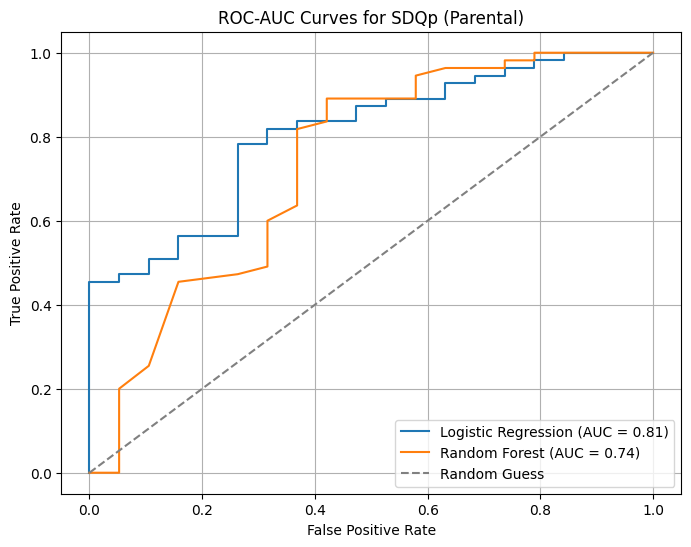


Feature Importance (Random Forest):
                        Feature  Importance
4   HYPERACTIVITY INATTENTION P    0.215210
1                           age    0.185736
7                 TOTAL SCORE P    0.135809
3            CONDUCT PROBLEMS P    0.120449
6             PROSOCIAL SCORE P    0.109593
2          EMOTIONAL SYMPTOMS P    0.102704
5  PEER RELATIONSHIP PROBLEMS P    0.101581
0                          Sexe    0.028918


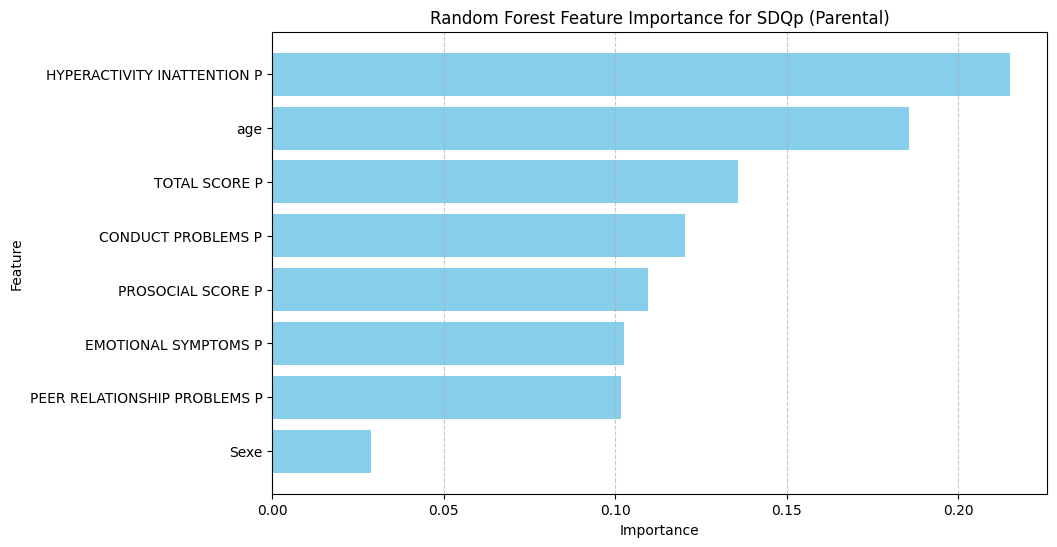


Logistic Regression with Interaction Terms AUC-ROC: 0.686

### ROC-AUC Analysis for SDQt (Teacher) ###

Logistic Regression AUC-ROC: 0.883
Random Forest AUC-ROC: 0.831

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.76      0.92      0.83        24

    accuracy                           0.74        34
   macro avg       0.68      0.61      0.62        34
weighted avg       0.71      0.74      0.70        34



C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


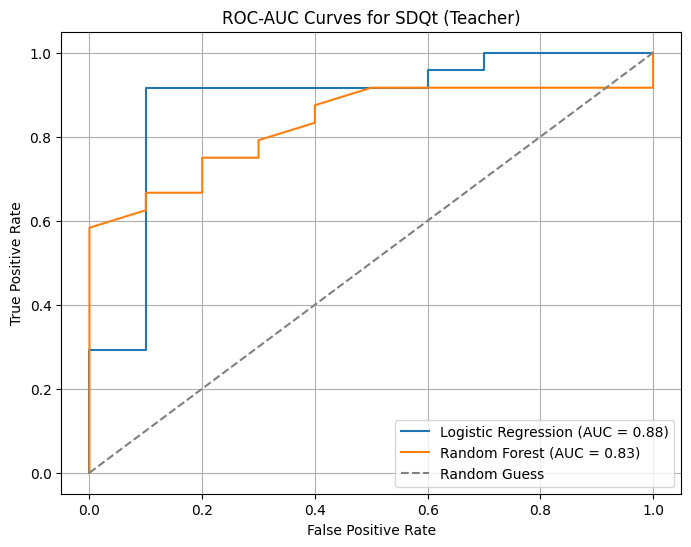


Feature Importance (Random Forest):
                        Feature  Importance
4   HYPERACTIVITY INATTENTION T    0.258375
7                 TOTAL SCORE T    0.164975
1                           age    0.124251
6             PROSOCIAL SCORE T    0.123222
2          EMOTIONAL SYMPTOMS T    0.122067
5  PEER RELATIONSHIP PROBLEMS T    0.101084
3            CONDUCT PROBLEMS T    0.081940
0                          Sexe    0.024086


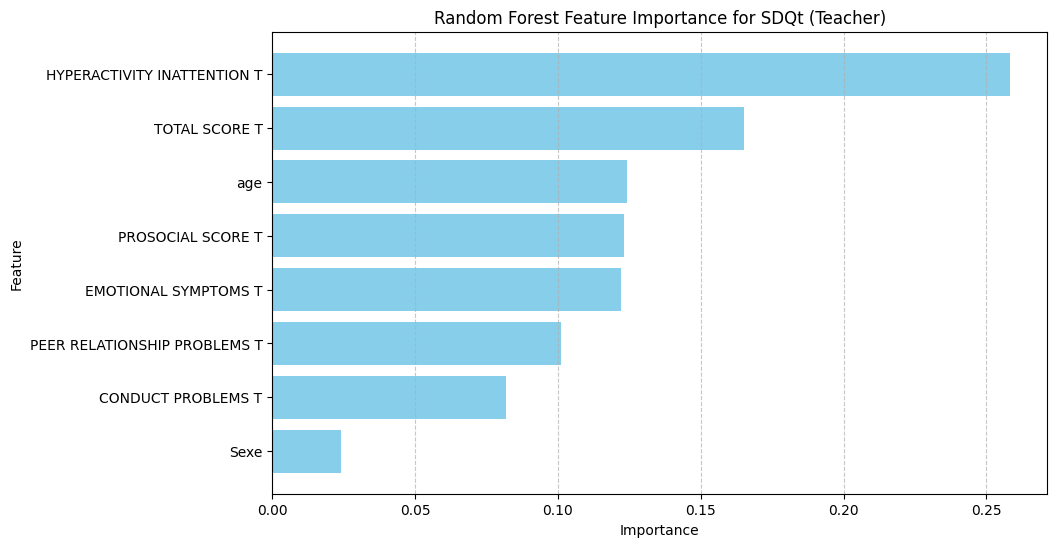


Logistic Regression with Interaction Terms AUC-ROC: 0.800


C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations

# Define predictors and target for each dataframe
predictors_sdqp = ['Sexe', 'age', 'EMOTIONAL SYMPTOMS P', 'CONDUCT PROBLEMS P', 'HYPERACTIVITY INATTENTION P',
                   'PEER RELATIONSHIP PROBLEMS P', 'PROSOCIAL SCORE P', 'TOTAL SCORE P']
predictors_sdqt = ['Sexe', 'age', 'EMOTIONAL SYMPTOMS T', 'CONDUCT PROBLEMS T', 'HYPERACTIVITY INATTENTION T',
                   'PEER RELATIONSHIP PROBLEMS T', 'PROSOCIAL SCORE T', 'TOTAL SCORE T']

target = 'ADHD'

# Create folders for saving results
def create_folders(base_path):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(f"{base_path}/figures", exist_ok=True)
    os.makedirs(f"{base_path}/stats", exist_ok=True)

# Function to perform ROC-AUC analysis with feature importance
def roc_auc_and_feature_importance_analysis(data, predictors, dataset_name, save_path):
    print(f"\n### ROC-AUC Analysis for {dataset_name} ###\n")

    # Create folders for saving output
    create_folders(save_path)

    X = data[predictors]
    y = data[target]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Logistic Regression
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X_train, y_train)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]
    log_auc = roc_auc_score(y_test, y_prob_log)
    log_stats = f"Logistic Regression AUC-ROC: {log_auc:.3f}"
    
    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, y_prob_rf)
    rf_stats = f"Random Forest AUC-ROC: {rf_auc:.3f}"

    # Classification Report
    rf_report = classification_report(y_test, rf_model.predict(X_test))
    print(log_stats)
    print(rf_stats)
    print("\nClassification Report (Random Forest):")
    print(rf_report)

    # Save text stats
    with open(f"{save_path}/stats/roc_auc_stats.txt", "w") as f:
        f.write(f"### ROC-AUC Analysis for {dataset_name} ###\n")
        f.write(log_stats + "\n")
        f.write(rf_stats + "\n")
        f.write("\nClassification Report (Random Forest):\n")
        f.write(rf_report)

    # Plot ROC Curves
    fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.2f})")
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-AUC Curves for {dataset_name}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig(f"{save_path}/figures/roc_auc_curve.png")
    plt.show()
    plt.close()
    
    # Feature Importance for Random Forest
    importances = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importance (Random Forest):")
    print(importance_df)

    importance_df.to_csv(f"{save_path}/stats/feature_importance.csv", index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Random Forest Feature Importance for {dataset_name}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.savefig(f"{save_path}/figures/feature_importance.png")
    plt.show()
    plt.close()

    # Interaction Analysis (Logistic Regression with Interactions)
    interaction_data = X.copy()
    for pair in combinations(predictors, 2):
        interaction_data[f"{pair[0]}_x_{pair[1]}"] = X[pair[0]] * X[pair[1]]

    X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(interaction_data, y, test_size=0.2, random_state=42)
    log_model_inter = LogisticRegression(max_iter=1000)
    log_model_inter.fit(X_train_inter, y_train_inter)
    y_prob_inter = log_model_inter.predict_proba(X_test_inter)[:, 1]
    auc_inter = roc_auc_score(y_test_inter, y_prob_inter)
    print(f"\nLogistic Regression with Interaction Terms AUC-ROC: {auc_inter:.3f}")

    with open(f"{save_path}/stats/interaction_auc_stats.txt", "w") as f:
        f.write(f"Logistic Regression with Interaction Terms AUC-ROC: {auc_inter:.3f}\n")

# Use existing dataframes (file_sdqp_clean and file_sdqt_clean)
roc_auc_and_feature_importance_analysis(file_sdqp_clean, predictors_sdqp, "SDQp (Parental)", "results/SDQp")
roc_auc_and_feature_importance_analysis(file_sdqt_clean, predictors_sdqt, "SDQt (Teacher)", "results/SDQt")


# 3.2) predictor Analysis with all data combined file:

Number of ADHD subjects: 133
Number of Control subjects: 35
Logistic Regression AUC-ROC: 0.925
Random Forest AUC-ROC: 0.915

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.86      1.00      0.92        24

    accuracy                           0.88        34
   macro avg       0.93      0.80      0.84        34
weighted avg       0.90      0.88      0.87        34



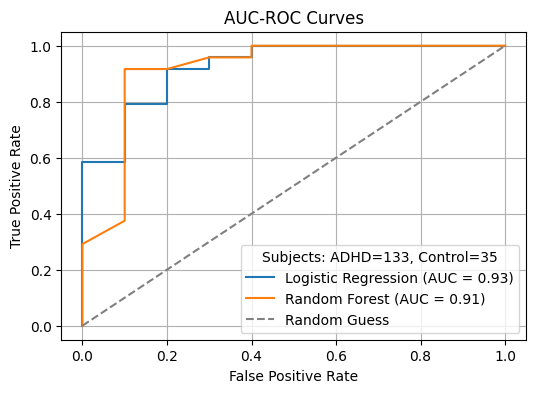

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Load the data
file = "sexAgeSDQpSDQtClean.csv"
data = pd.read_csv(file, sep=";", skip_blank_lines=True).dropna(how='all', axis=1)  # Drop empty columns

# Clean and preprocess
data.columns = data.columns.str.strip()  # Clean column names
data['ADHD'] = data['ADHD'].astype(int)  # Ensure ADHD is an integer
data['EMOTIONAL SYMPTOMS P'] = data['EMOTIONAL SYMPTOMS P'].fillna(0).astype(int) # Change NaN files

# Count the number of subjects per group
n_adhd = len(data[data['ADHD'] == 1])
n_control = len(data[data['ADHD'] == 0])

# Print the counts
print(f"Number of ADHD subjects: {n_adhd}")
print(f"Number of Control subjects: {n_control}")

# Define features and target
predictors = ['Sexe', 'age', 'EMOTIONAL SYMPTOMS P', 'CONDUCT PROBLEMS P', 'HYPERACTIVITY INATTENTION P',
              'PEER RELATIONSHIP PROBLEMS P', 'PROSOCIAL SCORE P', 'TOTAL SCORE P',
              'EMOTIONAL SYMPTOMS T', 'CONDUCT PROBLEMS T', 'HYPERACTIVITY INATTENTION T',
              'PEER RELATIONSHIP PROBLEMS T', 'PROSOCIAL SCORE T',  'TOTAL SCORE T']
X = data[predictors]
y = data['ADHD']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model: Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_prob_log = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, y_prob_log)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_prob_rf)

# Print Performance Metrics
print(f"Logistic Regression AUC-ROC: {log_auc:.3f}")
print(f"Random Forest AUC-ROC: {rf_auc:.3f}")
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_model.predict(X_test)))

# Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves")
plt.legend(loc="lower right")
# Add subject counts to legend
plt.legend(loc="lower right", title=f"Subjects: ADHD={n_adhd}, Control={n_control}")
plt.grid()
plt.savefig("AUC-ROC Curves P&T")
plt.show()


### 3.3) Explanation
Feature Importance:

The feature_importances_ attribute of the Random Forest model provides the relative importance of each predictor in the model.
Higher values indicate that the feature contributes more to the model's predictions.
Sorting and Visualization:

The importance values are sorted in descending order and plotted as a horizontal bar chart for easy interpretation.
Predictors:

Includes all predictors (sex, age, and SDQ scores/subscores).
Expected Output
Feature Importance Table:
A table showing each feature and its importance score (e.g., HYPERACTIVITY/INATTENTION P, age, etc.).
Feature Importance Plot:
A bar chart showing the relative importance of each feature, sorted from most to least important.
Interpretation
Top Features:

Identify which predictors (e.g., SDQ subscores, age, or sex) are most important for ADHD classification.
For example:
HYPERACTIVITY/INATTENTION P might have the highest importance if hyperactivity is a strong indicator of ADHD.
Low-Importance Features:

Features with very low importance may contribute little to the model and could potentially be excluded in future analyses to simplify the model.


### 3.4) Cross Validation:

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define features and target
X = data[predictors]
y = data['ADHD']

# Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)

# Perform 5-fold cross-validation for Logistic Regression
log_cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='roc_auc')
print(f"Logistic Regression Cross-Validated AUC-ROC: {np.mean(log_cv_scores):.3f} ± {np.std(log_cv_scores):.3f}")

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Perform 5-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='roc_auc')
print(f"Random Forest Cross-Validated AUC-ROC: {np.mean(rf_cv_scores):.3f} ± {np.std(rf_cv_scores):.3f}")


Logistic Regression Cross-Validated AUC-ROC: 0.804 ± 0.137
Random Forest Cross-Validated AUC-ROC: 0.826 ± 0.100


### 3.5) Feature Importance Analysis

                         Feature  Importance
10   HYPERACTIVITY INATTENTION T    0.172984
4    HYPERACTIVITY INATTENTION P    0.142903
7                  TOTAL SCORE P    0.088588
13                 TOTAL SCORE T    0.077035
1                            age    0.068550
2           EMOTIONAL SYMPTOMS P    0.061792
3             CONDUCT PROBLEMS P    0.059762
5   PEER RELATIONSHIP PROBLEMS P    0.055931
11  PEER RELATIONSHIP PROBLEMS T    0.055673
9             CONDUCT PROBLEMS T    0.052517
8           EMOTIONAL SYMPTOMS T    0.049645
12             PROSOCIAL SCORE T    0.049034
6              PROSOCIAL SCORE P    0.048164
0                           Sexe    0.017424


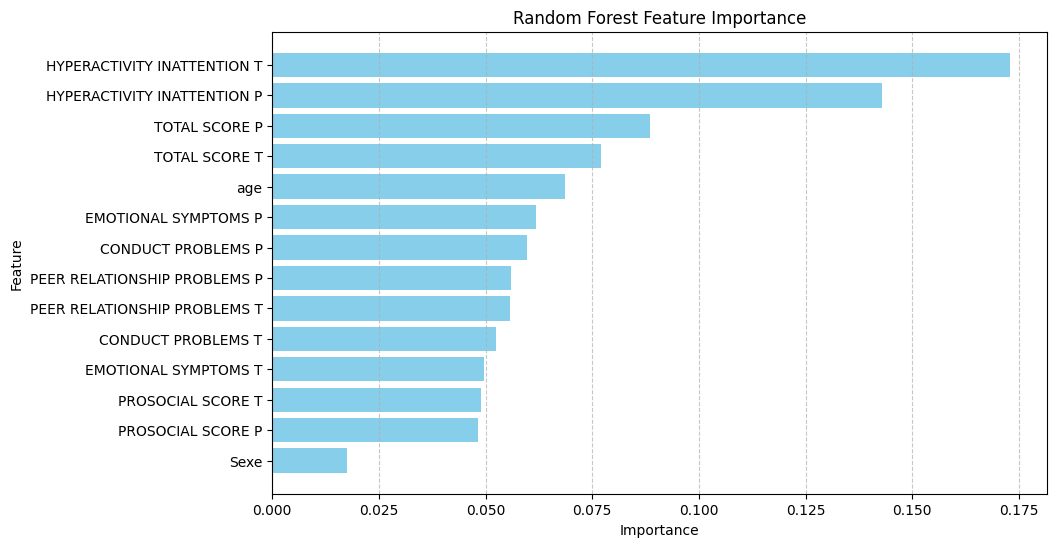

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train the Random Forest model if not already trained
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("Random Forest P&Q")
plt.show()


### 3.6) Retrain with Top Predictors:
'HYPERACTIVITY/INATTENTION T', 
'HYPERACTIVITY/INATTENTION P', 
'TOTAL SCORE P', 'TOTAL SCORE T', 
'CONDUCT PROBLEMS P', 'EMOTIONAL SYMPTOMS P',
'age'

In [3]:
# Select top 5 predictors based on feature importance
top_predictors = ['HYPERACTIVITY INATTENTION T', 
                  'HYPERACTIVITY INATTENTION P', 
                  'TOTAL SCORE P', 'TOTAL SCORE T', 
                  'CONDUCT PROBLEMS P', 'EMOTIONAL SYMPTOMS P',
                  'age']

# Define new feature set
X_top = data[top_predictors]
y = data['ADHD']

# Train-test split
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Retrain Random Forest on top predictors
rf_model_top = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_top.fit(X_train_top, y_train_top)

# Evaluate the model on the test set
y_prob_rf_top = rf_model_top.predict_proba(X_test_top)[:, 1]
rf_auc_top = roc_auc_score(y_test_top, y_prob_rf_top)

# Compare performance with full model
print(f"Random Forest (Full Model) AUC-ROC: {rf_auc:.3f}")
print(f"Random Forest (Top Predictors) AUC-ROC: {rf_auc_top:.3f}")

# Classification report for the reduced model
print("\nClassification Report for Top Predictors Model:")
print(classification_report(y_test_top, rf_model_top.predict(X_test_top)))

# Plot ROC curves for comparison
fpr_rf_top, tpr_rf_top, _ = roc_curve(y_test_top, y_prob_rf_top)

plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Full Model (AUC = {rf_auc:.2f})", linestyle='--')
plt.plot(fpr_rf_top, tpr_rf_top, label=f"Top Predictors Model (AUC = {rf_auc_top:.2f})", linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of AUC-ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("Comparison of AUC-ROC Curves P&Q top predictors")
plt.show()


NameError: name 'data' is not defined

## 3.7) Test With Interactions

In [66]:
from itertools import combinations

# Define top predictors
top_predictors = [
    'HYPERACTIVITY INATTENTION T', 
    'HYPERACTIVITY INATTENTION P', 
    'TOTAL SCORE P', 'TOTAL SCORE T', 
    'CONDUCT PROBLEMS P', 'EMOTIONAL SYMPTOMS P',
    'age'
]

# Add interaction terms for all pairs of predictors
interaction_data = data[top_predictors].copy()
for pair in combinations(top_predictors, 2):
    interaction_data[f"{pair[0]}_x_{pair[1]}"] = data[pair[0]] * data[pair[1]]

# Combine original predictors and interaction terms
X_interaction = interaction_data
y = data['ADHD']


In [67]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(X_interaction, y, test_size=0.2, random_state=42)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Logistic Regression
log_model_inter = LogisticRegression(max_iter=1000)
log_model_inter.fit(X_train_inter, y_train_inter)

# Evaluate performance
y_prob_log_inter = log_model_inter.predict_proba(X_test_inter)[:, 1]
log_auc_inter = roc_auc_score(y_test_inter, y_prob_log_inter)

# Classification report
print(f"Logistic Regression with Interactions AUC-ROC: {log_auc_inter:.3f}")
print("\nClassification Report for Interaction Model:")
print(classification_report(y_test_inter, log_model_inter.predict(X_test_inter)))

# ROC Curve
fpr_inter, tpr_inter, _ = roc_curve(y_test_inter, y_prob_log_inter)
plt.figure(figsize=(6, 4))
plt.plot(fpr_inter, tpr_inter, label=f"Logistic Regression with Interactions (AUC = {log_auc_inter:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for Logistic Regression with Interactions")
plt.legend(loc="lower right")
plt.grid()
plt.savefig("AUC-ROC Curve with interactions")
plt.show()


NameError: name 'X_train_inter' is not defined

In [18]:
import statsmodels.api as sm

# Add constant for statsmodels
X_train_inter_const = sm.add_constant(X_train_inter)

# Fit logistic regression using statsmodels
logit_model = sm.Logit(y_train_inter, X_train_inter_const)
result = logit_model.fit()

# Summary of model coefficients and p-values
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.258302
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                   ADHD   No. Observations:                  134
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                           28
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.4632
Time:                        14:46:26   Log-Likelihood:                -34.612
converged:                       True   LL-Null:                       -64.482
Covariance Type:            nonrobust   LLR p-value:                 0.0004398
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const         

### 3.8) Tree based Models for Feature Importance:

                                              Feature  Importance
7   HYPERACTIVITY INATTENTION T_x_HYPERACTIVITY IN...    0.113470
0                         HYPERACTIVITY INATTENTION T    0.072465
9         HYPERACTIVITY INATTENTION T_x_TOTAL SCORE T    0.062784
12                  HYPERACTIVITY INATTENTION T_x_age    0.059358
1                         HYPERACTIVITY INATTENTION P    0.053265
13        HYPERACTIVITY INATTENTION P_x_TOTAL SCORE P    0.052794
17                  HYPERACTIVITY INATTENTION P_x_age    0.052192
8         HYPERACTIVITY INATTENTION T_x_TOTAL SCORE P    0.046234
24                                TOTAL SCORE T_x_age    0.035867
15   HYPERACTIVITY INATTENTION P_x_CONDUCT PROBLEMS P    0.033255
11  HYPERACTIVITY INATTENTION T_x_EMOTIONAL SYMPTO...    0.031930
27                         EMOTIONAL SYMPTOMS P_x_age    0.031574
14        HYPERACTIVITY INATTENTION P_x_TOTAL SCORE T    0.030255
18                      TOTAL SCORE P_x_TOTAL SCORE T    0.029115
21        

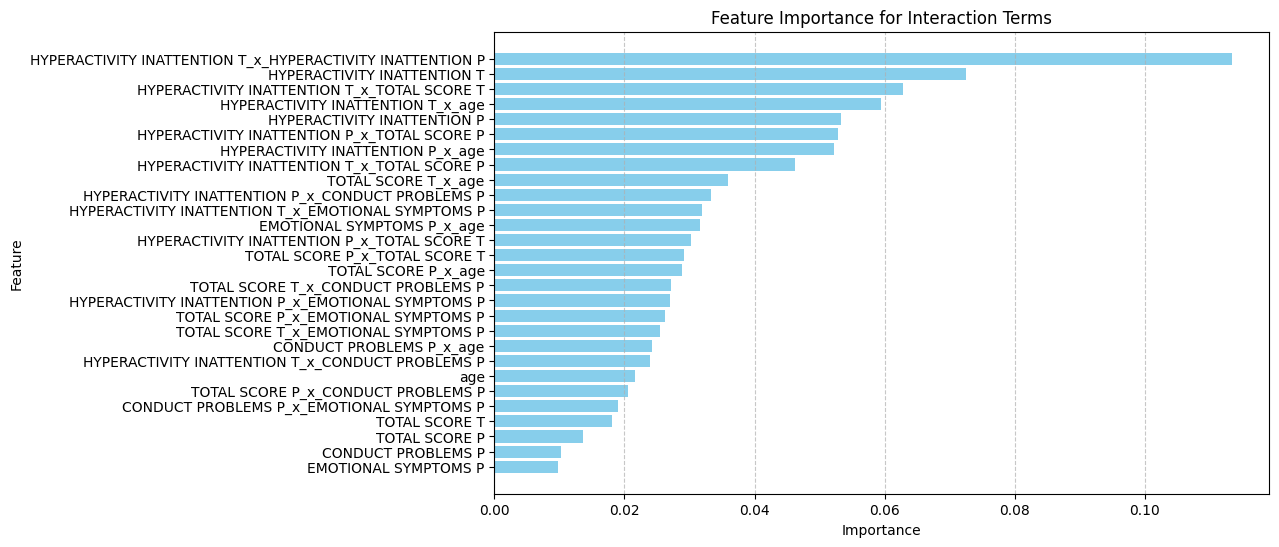

In [69]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model with interaction terms
rf_model_inter = RandomForestClassifier(random_state=42)
rf_model_inter.fit(X_train_inter, y_train_inter)

# Get feature importance
feature_importances = rf_model_inter.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X_train_inter.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display top features
print(importance_df)

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Interaction Terms')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig("Feature Importance for Interaction Terms P&Q")
plt.show()


### 3.9) Performance Comparison

In [20]:
# Logistic Regression without interaction terms
log_model_no_inter = LogisticRegression(max_iter=1000)
log_model_no_inter.fit(X_train, y_train)
y_prob_no_inter = log_model_no_inter.predict_proba(X_test)[:, 1]
auc_no_inter = roc_auc_score(y_test, y_prob_no_inter)

# Logistic Regression with interaction terms
y_prob_with_inter = log_model_inter.predict_proba(X_test_inter)[:, 1]
auc_with_inter = roc_auc_score(y_test_inter, y_prob_with_inter)

# Print AUC comparison
print(f"Model without interactions AUC-ROC: {auc_no_inter:.3f}")
print(f"Model with interactions AUC-ROC: {auc_with_inter:.3f}")


Model without interactions AUC-ROC: 0.925
Model with interactions AUC-ROC: 0.708


# 4-bis) New analysis for sexAgeSDQpClean.csv file:
It has more n for the parental assessments.

#### Open the file and shows descriptice statistics about the columns (n=369)

Columns in the dataset: ['Sexe', 'age', 'ADHD', 'EMOTIONAL SYMPTOMS T', 'CONDUCT PROBLEMS T', 'HYPERACTIVITY/INATTENTION T', 'PEER RELATIONSHIP PROBLEMS T', 'PROSOCIAL SCORE T', 'TOTAL SCORE']

Summary Statistics:
             Sexe         age        ADHD  EMOTIONAL SYMPTOMS T  \
count  369.000000  369.000000  369.000000            369.000000   
mean     0.644986    9.718157    0.796748              4.761518   
std      0.479167    2.665545    0.402965              2.926181   
min      0.000000    6.000000    0.000000              0.000000   
25%      0.000000    8.000000    1.000000              2.000000   
50%      1.000000    9.000000    1.000000              4.000000   
75%      1.000000   12.000000    1.000000              7.000000   
max      1.000000   16.000000    1.000000             10.000000   

       CONDUCT PROBLEMS T  HYPERACTIVITY/INATTENTION T  \
count          369.000000                   369.000000   
mean             3.737127                     6.569106   
std     

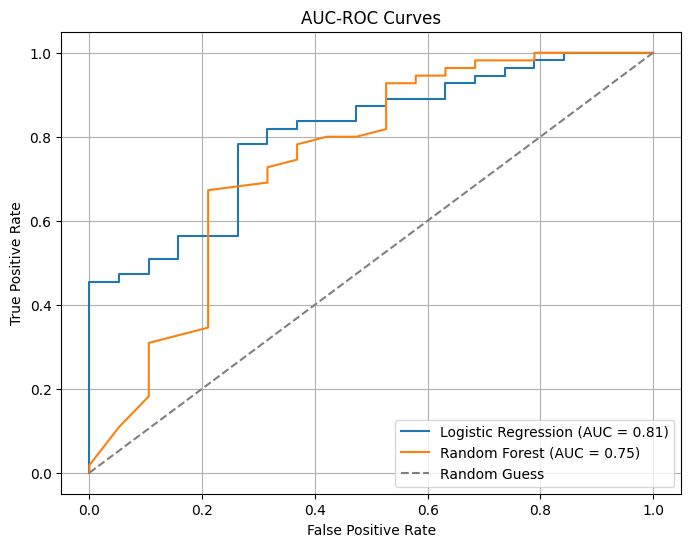


Feature Importance (Random Forest):
                        Feature  Importance
0   HYPERACTIVITY/INATTENTION T    0.219832
6                           age    0.168205
5                   TOTAL SCORE    0.129791
1            CONDUCT PROBLEMS T    0.127889
3  PEER RELATIONSHIP PROBLEMS T    0.115780
4             PROSOCIAL SCORE T    0.108022
2          EMOTIONAL SYMPTOMS T    0.099154
7                          Sexe    0.031329


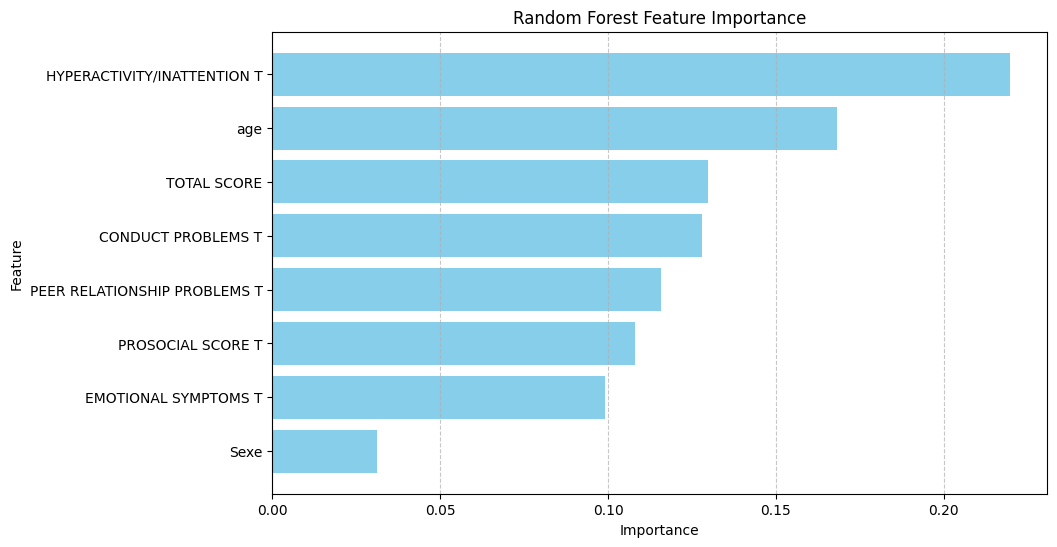


Logistic Regression with Interaction Terms AUC-ROC: 0.683


C:\Users\damie\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve

# 1. Load and Clean the Data

# Load the new dataset
file = "sexAgeSDQpClean.csv"
data = pd.read_csv(file, sep=";", skip_blank_lines=True).dropna(how="all", axis=1)

# Clean column names
data.columns = data.columns.str.strip()
data['EMOTIONAL SYMPTOMS T'] = data['EMOTIONAL SYMPTOMS T'].fillna(0).astype(int) # Change NaN files + make sure it is integer

# Print column names for debugging
print("Columns in the dataset:", data.columns.tolist())

# Descriptive summary
print("\nSummary Statistics:")
print(data.describe(include="all"))

# Check for missing values in each column
print("\nMissing Values Per Column:")
print(data.isna().sum())

# 3. Define Predictors and Target
predictors = [
    'HYPERACTIVITY/INATTENTION T', 
    'CONDUCT PROBLEMS T', 
    'EMOTIONAL SYMPTOMS T', 
    'PEER RELATIONSHIP PROBLEMS T', 
    'PROSOCIAL SCORE T', 
    'TOTAL SCORE', 
    'age', 
    'Sexe'
]
X = data[predictors]
y = data['ADHD']

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_prob_log = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, y_prob_log)

print(f"\nLogistic Regression AUC-ROC: {log_auc:.3f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, log_model.predict(X_test)))

# 6. Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_prob_rf)

print(f"\nRandom Forest AUC-ROC: {rf_auc:.3f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_model.predict(X_test)))

# 7. ROC Curve Comparison
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Feature Importance Analysis for Random Forest
importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 9. Interaction Analysis (Optional)
from itertools import combinations

interaction_data = X.copy()
for pair in combinations(predictors, 2):
    interaction_data[f"{pair[0]}_x_{pair[1]}"] = X[pair[0]] * X[pair[1]]

X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(interaction_data, y, test_size=0.2, random_state=42)

log_model_inter = LogisticRegression(max_iter=1000)
log_model_inter.fit(X_train_inter, y_train_inter)

y_prob_inter = log_model_inter.predict_proba(X_test_inter)[:, 1]
auc_inter = roc_auc_score(y_test_inter, y_prob_inter)

print(f"\nLogistic Regression with Interaction Terms AUC-ROC: {auc_inter:.3f}")


#### Histograms:

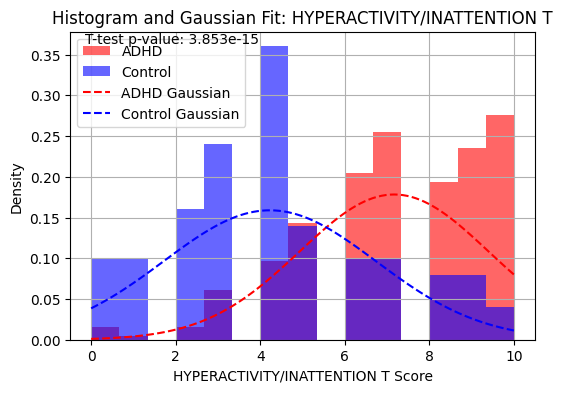

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\damie\\Documents\\GitHub\\SDQ_adhd_predictor\\HYPERACTIVITY\\INATTENTION T_P.png'

<Figure size 640x480 with 0 Axes>

In [53]:
from scipy.stats import ttest_ind, norm

# 3. Histograms and Statistical Tests
for predictor in predictors:
    # Separate ADHD and Control groups
    adhd_group = data[data['ADHD'] == 1][predictor]
    control_group = data[data['ADHD'] == 0][predictor]

    # Fit Gaussian distributions
    adhd_mean, adhd_std = norm.fit(adhd_group)
    control_mean, control_std = norm.fit(control_group)

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(adhd_group, bins=15, alpha=0.6, color='red', density=True, label='ADHD')
    plt.hist(control_group, bins=15, alpha=0.6, color='blue', density=True, label='Control')

    # Overlay Gaussian distributions
    x = np.linspace(min(data[predictor]), max(data[predictor]), 100)
    plt.plot(x, norm.pdf(x, adhd_mean, adhd_std), color='red', linestyle='--', label='ADHD Gaussian')
    plt.plot(x, norm.pdf(x, control_mean, control_std), color='blue', linestyle='--', label='Control Gaussian')

    # Add title, labels, and legend
    plt.title(f"Histogram and Gaussian Fit: {predictor}")
    plt.xlabel(f"{predictor} Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()

    # Perform a statistical test
    t_stat, p_value = ttest_ind(adhd_group.dropna(), control_group.dropna(), equal_var=False)
    plt.figtext(0.15, 0.85, f"T-test p-value: {p_value:.3e}", fontsize=10, color='black')

    # Show plot
    plt.show()
    plt.savefig(f"{predictor}_P")

### Train, Log regression, Random forrest, ROC curves


Logistic Regression AUC-ROC: 0.806

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.80      0.21      0.33        19
           1       0.78      0.98      0.87        55

    accuracy                           0.78        74
   macro avg       0.79      0.60      0.60        74
weighted avg       0.79      0.78      0.73        74


Random Forest AUC-ROC: 0.745

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.26      0.40        19
           1       0.79      0.98      0.88        55

    accuracy                           0.80        74
   macro avg       0.81      0.62      0.64        74
weighted avg       0.80      0.80      0.76        74



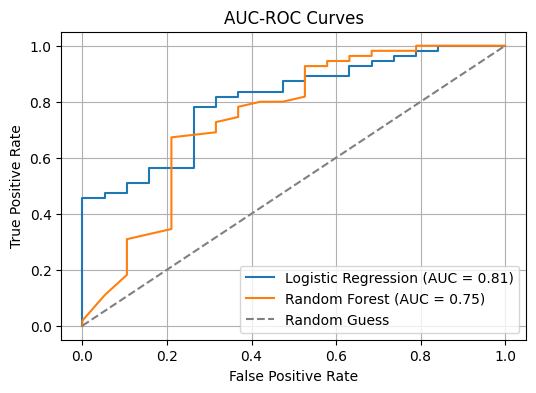

In [55]:
# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Logistic Regression Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_prob_log = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, y_prob_log)

print(f"\nLogistic Regression AUC-ROC: {log_auc:.3f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, log_model.predict(X_test)))

# 6. Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_prob_rf)

print(f"\nRandom Forest AUC-ROC: {rf_auc:.3f}")
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_model.predict(X_test)))

# 7. ROC Curve Comparison
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {log_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.savefig('AUC-ROC_P.png')
plt.show()


### Feature Importance Analysis for Random Forest


Feature Importance (Random Forest):
                        Feature  Importance
0   HYPERACTIVITY/INATTENTION T    0.219832
6                           age    0.168205
5                   TOTAL SCORE    0.129791
1            CONDUCT PROBLEMS T    0.127889
3  PEER RELATIONSHIP PROBLEMS T    0.115780
4             PROSOCIAL SCORE T    0.108022
2          EMOTIONAL SYMPTOMS T    0.099154
7                          Sexe    0.031329


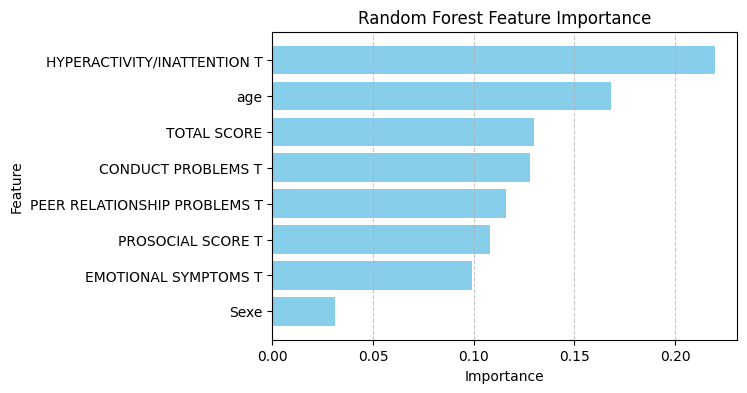

In [56]:
# 8. Feature Importance Analysis for Random Forest
importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(importance_df)

plt.figure(figsize=(6, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('RandForest_P.png')
plt.show()


## #TODO
Refine Predictors:
Retrain the model with only the significant interaction terms and evaluate performance